<a href="https://colab.research.google.com/github/adamtoast5/Adam_colab_host/blob/main/Spectrum_Analysis_2024%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Anthony Butterfield, Chemical Engienering, University of Utah. No rights reserved.

# Code for analysis of UV-Vis and FTIR spectra

Start by importing the stuff we need:

In [80]:
%cd /content
!rm -rf Adam_colab_host
!git clone https://github.com/adamtoast5/Adam_colab_host.git
!git pull

/content
Cloning into 'Adam_colab_host'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 75 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 4.20 MiB | 7.74 MiB/s, done.
Resolving deltas: 100% (1/1), done.
fatal: not a git repository (or any of the parent directories): .git


In [81]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.core.display import HTML

Functions used to normalize all the spectrum to same max intensities and baselines:

In [82]:
def ConditionFTIRdata(x,y):  #make it all the same scale
    #baseline to 100%
    i=np.where( (x>550) & (x<3750)) #any data below this is just noise due to the ATR attachment
    ymx=np.max(y[i]) #need to see if the data was recorded as A or T
    if (ymx<10):#if max value is < 10 then it's A and we need to convert to T from A
        y=np.exp(-y) #convert to T
        ymx=np.max(y[i]) # find new max
    ymn=np.min(y[i]) #get min
    y=100*(y-ymn)/(ymx-ymn) #normalize all spectra to the have their min be 0 and max be 100% T
    i=np.where(x>3500) #a range in which most spectra have 100% T
    mean100 = np.mean(y[i])
    y=y-mean100+100 #adjust all plots to have the same baseline
    #find ymin
    i=np.where((x>1000) & (x<3500))
    ymin=np.min(y[i])
    return y,ymin

def ConditionUVVisdata(x,y):  #make it all the same scale
    i=np.where((x<1100) & (x>400))
    ymn=np.min(y[i])
    ymx=np.max(y[i])
    if (ymx<10):#need to convert to T from A
        y=np.exp(-y)
        ymn=np.min(y[i])
        ymx=np.max(y[i])
    y=100*(y-ymn)/(ymx-ymn)
    ymin=ymn
    return y,ymin

In [83]:
def PlotThemSpecLines(ids):
    try:
        if int(ids[0])==0: #is it a list of numbers?
            ids=list(range(0,n))
    except:
        if (str(ids[0])=='o'):#all oils
            ids=list(oils)
        elif (str(ids[0])=='b'):#all biodiesels
            ids=list(biods)
        else:#all other materials
            ids=list(miscs)
    #the various colors for multiple lines
    clrs     = [[1,0,0],[0,1,1],[1,.5,0],[0,.5,1],[1,1,0],[0,0,1],[0.5,1,0],[.5,0,1],[0,1,0],[1,0,1],[0,1,.5],[1,0,.5]]
    nclr=len(clrs)
    lss = ['-',':','--','-.']  #various line styles
    nls=len(lss)
    ymn=float('inf')
    for ifiles in ids:
        print(ifiles, end='')
        if (ifiles!=ids[-1]): print(', ', end='')
        x,y,strings = [], [], [] #initiate the time and temeprature vectors

        with open(path+fname[int(ifiles)-1], 'r') as f:
            reader = csv.reader(f)
            i,j = 0,0
            for row in reader: #loop through rows
                try:
                    x.append(float(row[0]))#convert time string into number and append
                    y.append(float(row[1]))#ditto
                except ValueError:
                    strings.append(row[0])
            x=np.array(x)
            y=np.array(y)
            if (isFTIR):
                y,ym=ConditionFTIRdata(x,y)
            else:
                y,ym=ConditionUVVisdata(x,y)
            if (ym<ymn): ymn=ym
            plt.plot(x,y,c=np.array(clrs[int(ifiles)%nclr])*(np.round( (int(ifiles)/2-.1) )%2+1)/2, ls=lss[(int(ifiles)//nclr)%nls], label=fname[int(ifiles)-1].split('.')[0])
    if (isFTIR):
        plt.xlim([540, 3990])
        plt.ylim(ymin=ymn)
        plt.ylim(ymax=100)
        plt.gca().invert_xaxis()
        plt.xlabel('Wave Number')
    else:
        plt.xlim([400, 1100])
        plt.ylim([0, 100])
        plt.xlabel('Wave Length (nm)')
    plt.ylabel('% Transmittance')
    plt.legend()

Choose if you're analyzing FTIR or UV-Vis spectra (IIWY I'd make a separate notebook for the spectra of interest to me for each type of spectrophotometry):

In [84]:
#path string to either FTIR data or UV-Vis Data
#Make sure the FTIR and UV-Vis data folders are in the same folder as this code and they are named as they are named below
path = '/content/Adam_colab_host/FTIR Spectra/'
#path = '/content/Adam_colab_host/UV-Vis Spectra/'

isFTIR=False  #is it ftir or uv-vis?
spectxt = 'UV-Vis'
if 'ftir' in path.lower():
    isFTIR=True
    spectxt='FTIR'

f = os.listdir(path)  #get all the file names in the folder
txt=''
n=0 #counter
fname=[]
for i in f:
    isplt = i.split('.')  #split by .
    if (isplt[-1].upper()=='CSV'):  #only find csv files and make text to show user for selection
        fname.append(i)
fname=sorted(fname)
oils=[]#list of the oil ids
biods=[]#list of the biod ids
miscs=[]#list of the misc ids
for i in fname:
    n+=1
    isplt = i.split('.')  #split by .
    ispltsplt=isplt[0].split('-') #split by -
    txt0='{0:3d}. '.format(n)
    for j in ispltsplt:
        txt0 += '{0:15s}'.format(str(j))
        if ('oil' in j.lower()):
            oils.append(n)
        elif ('biod' in j.lower()):
            biods.append(n)
    if len(ispltsplt)==1:
        miscs.append(n)
    txt += '{0:40s}'.format(txt0)
    if (n%3==0):
        txt += '\n'
print('A list of all the {} spectra:'.format(spectxt))
print(txt)
print('Note: This stopped monospacing in VS Code and so it messes up the column alignment, but it works in anaconda jupyter notebook...')

A list of all the FTIR spectra:
  1. Avacado        BioD(2D)              2. Castor         BioD(2C)              3. Conola         BioD(3I)            
  4. Corn           BioD(3E)              5. Grapeseed      BioD(3C)              6. Hemp           BioD(e(2F)          
  7. Hemp           BoiD(3A)              8. Palm           BioD(2X)              9. Peanut         BioD(2H)            
 10. Peanut         BioD(3B)             11. Sesamie        BioD(2A)             12. Soybean        BioD(3H)            
 13. Sunflower      BioD(2E)             14. Sunflower      BioD(3G4)            15. Vegtable       BioD(3F)            
 16. Walnut         BioD(2B)             17. Walnut         BoiD(3D)             18. acetone                            
 19. algae          oil                  20. avocado        oil                  21. banana         oil                 
 22. canola         oil                  23. castor         oil                  24. chicken        oil                 


### An example of how to pick certain spectra and plot:

1, 20, 29

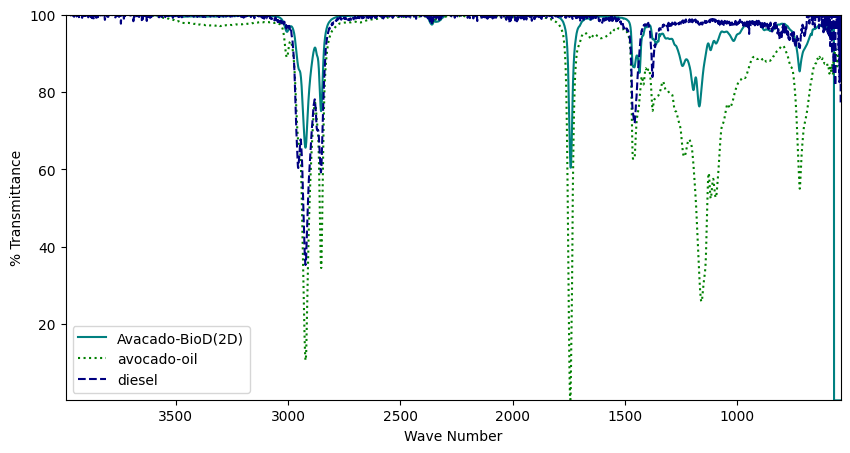

In [91]:
matplotlib.rcParams['figure.figsize'] = [10, 5] #making the plots a tad bigger - width, height
TheIds = [1, 20,29]
PlotThemSpecLines(TheIds)


### An example of how to plot everything:
Of course, you shouldn't have a plot with nearly this many lines in your report... I'd not have a plot with more than 10 lines and less than 5 is probably best for most plots.

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41

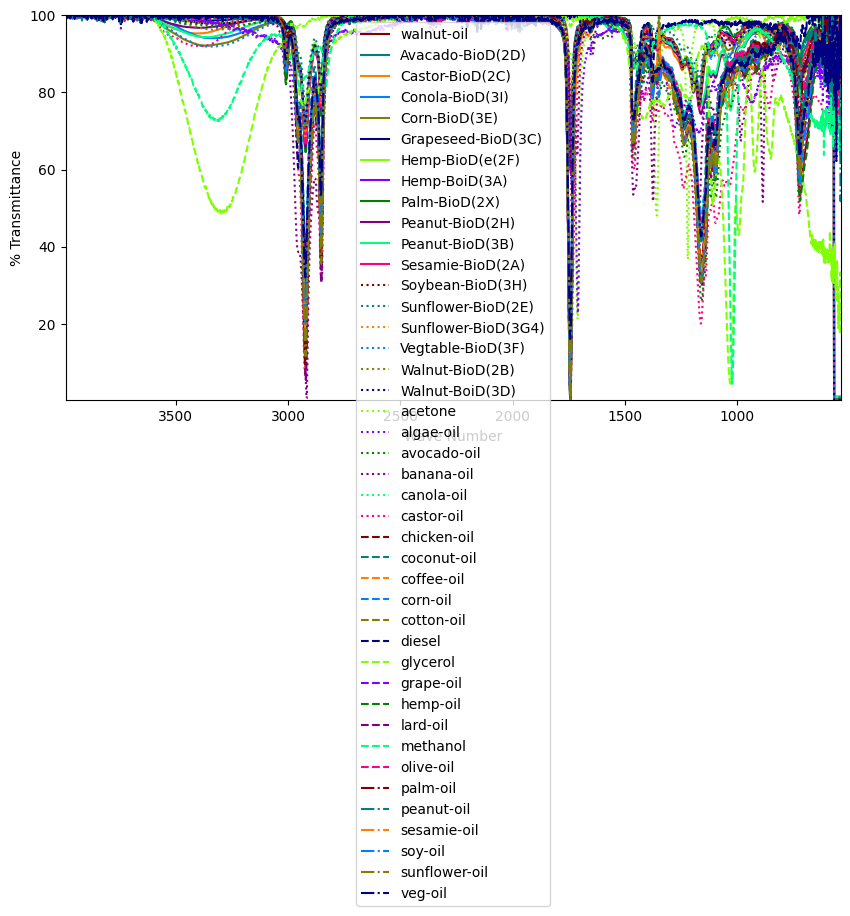

In [86]:
TheIds = [0]
PlotThemSpecLines(TheIds)

### An example of how to plot only the biodiesel:

1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16

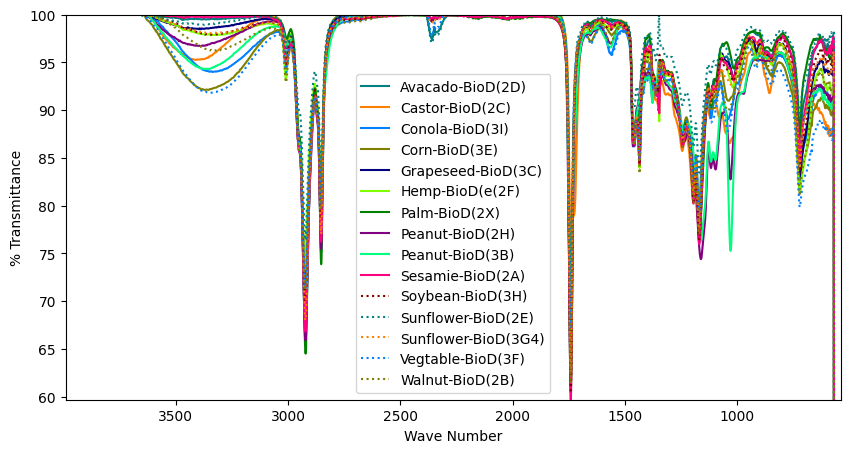

In [87]:
TheIds = 'b'
PlotThemSpecLines(TheIds)

### An example of how to plot only the oils:

19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42

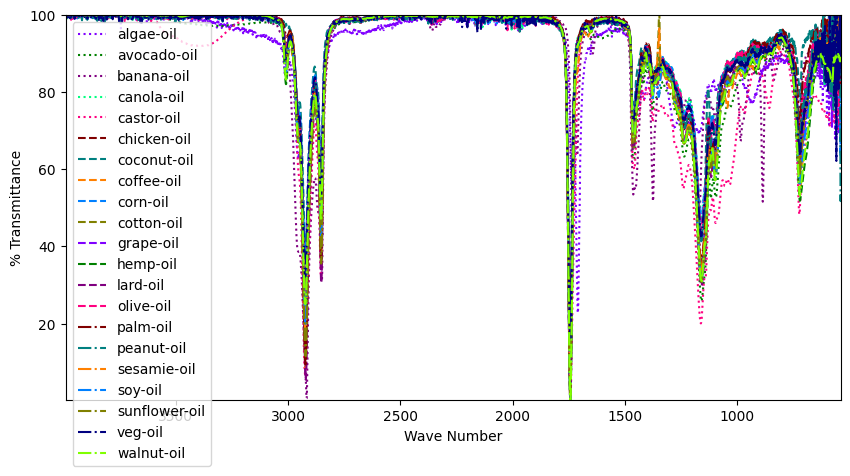

In [88]:
TheIds = 'o'
PlotThemSpecLines(TheIds)